In [1]:
from dolfin import *
from fenics import *
import scipy.sparse as sp
import matplotlib.pyplot as plt

In [2]:
meshlevel = 100
degree = 1
dim = 2
mesh = UnitDiscMesh.create(MPI.comm_world, meshlevel, degree, dim)

In [4]:
V = FunctionSpace(mesh, "Lagrange", 1)

In [5]:
def boundary(x):
    boundary = near(x[0]**2 + x[1]**2, 1, 1e-2)
    return boundary

In [6]:
u0 = Constant(0.)
bc = DirichletBC(V, u0, boundary)

In [7]:
# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Expression("1 - pow(x[0], 2) - pow(x[1], 2)", degree=2)
a = inner(grad(u), grad(v))*dx
L = f*v*dx

In [8]:
u = Function(V)
solve(a == L, u, bc)

Solving linear variational problem.


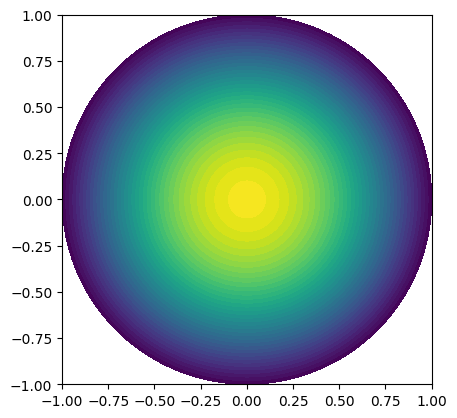

In [9]:
plot(u)
plt.show()

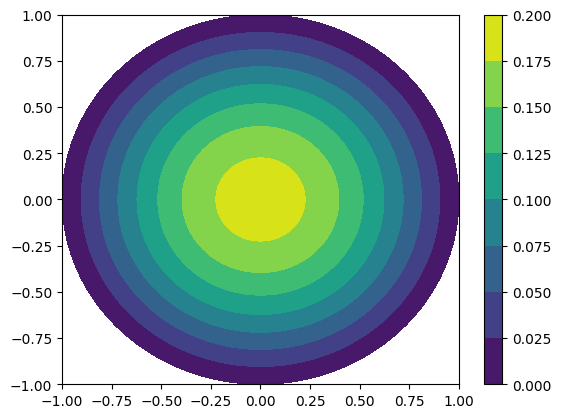

In [10]:
# reproduce the above
x = mesh.coordinates()
u_val = u.compute_vertex_values(mesh)
u_val.shape, u_val
plt.tricontourf(x[:,0], x[:,1], u_val)
plt.colorbar()
plt.show()

### FEniCS to scipy.sparse

In [11]:
# accounting for essential boundary condition
A, b = assemble_system(a, L, bcs=bc)
# conversion to sparse matrix and vector
A_sp = sp.csr_matrix(as_backend_type(A).mat().getValuesCSR()[::-1])
b_vec = as_backend_type(b).vec().getArray()

In [13]:
# direct sparse solver, sol = A \ b
uhat = sp.linalg.spsolve(A_sp, b_vec)

In [14]:
# due to the sparsity pattern, reordering is necessary.
ind = vertex_to_dof_map(V)
plt.tricontourf(x[:,0], x[:,1], uhat[ind])
plt.colorbar()
plt.show()

In [19]:
# check, relative L1
abs(u_val - uhat[ind]).sum() / abs(u_val).sum()

1.0012811798916677e-13